In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import phate

In [87]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [88]:
#| export
def branch_data_clean(t, e):
    shapes = (len(e), len(t))
    t = t.reshape(1,-1)
    e = e.reshape(-1, 1)
    ts = np.tile(t, (shapes[0], 1))[...,None]
    es = np.tile(e, (1, shapes[1]))[...,None]
    x = np.tile(t, (shapes[0], 1))
    y = e * t**2
    data = np.stack([x,y], axis=2)
    data = np.concatenate((ts, es, data), axis=-1)
    data = data.reshape(shapes[0]*shapes[1], -1)
    return data
def branch_data_data(data, n_colors=5, repeats=5, noisex=0.05, noisey=0.05, seed=32):
    data = np.tile(data, (repeats,1))
    df = pd.DataFrame(data, columns=['t', 'e1', 'd1', 'd2'])
    np.random.seed(seed)
    df['d1'] += np.random.randn(df.shape[0]) * noisex
    df['d2'] += np.random.randn(df.shape[0]) * noisey
    _, bin_edges = np.histogram(df['t'], bins=n_colors)
    bin_indices = np.digitize(df['t'], bin_edges)
    bin_indices[bin_indices > n_colors] = n_colors
    df.insert(0, 'samples', bin_indices)
    df.drop(columns=['t'], inplace=True)
    df.samples -=1
    return df
def make_branch_cond(nt=20, ne=3, n_colors=5, repeats=10, noisex=0.1, noisey=0.1, seed=32):
    t = np.linspace(0,1,nt)
    e = np.linspace(-1,1,ne)
    data = branch_data_clean(t, e)
    df = branch_data_data(data, n_colors, repeats, noisex, noisey, seed)
    return df

df = make_branch_cond(ne=2, repeats=20)


In [89]:
df

samples   e1        d1        d2
0          0 -1.0 -0.034889  0.054968
1          0 -1.0  0.151002  0.029287
2          0 -1.0  0.163355 -0.059603
3          0 -1.0  0.164923 -0.072056
4          1 -1.0  0.288280 -0.067361
..       ...  ...       ...       ...
795        3  1.0  0.932206  0.523483
796        4  1.0  0.930819  0.788406
797        4  1.0  1.034536  0.757093
798        4  1.0  0.839130  0.880604
799        4  1.0  0.925176  1.218131

[800 rows x 4 columns]

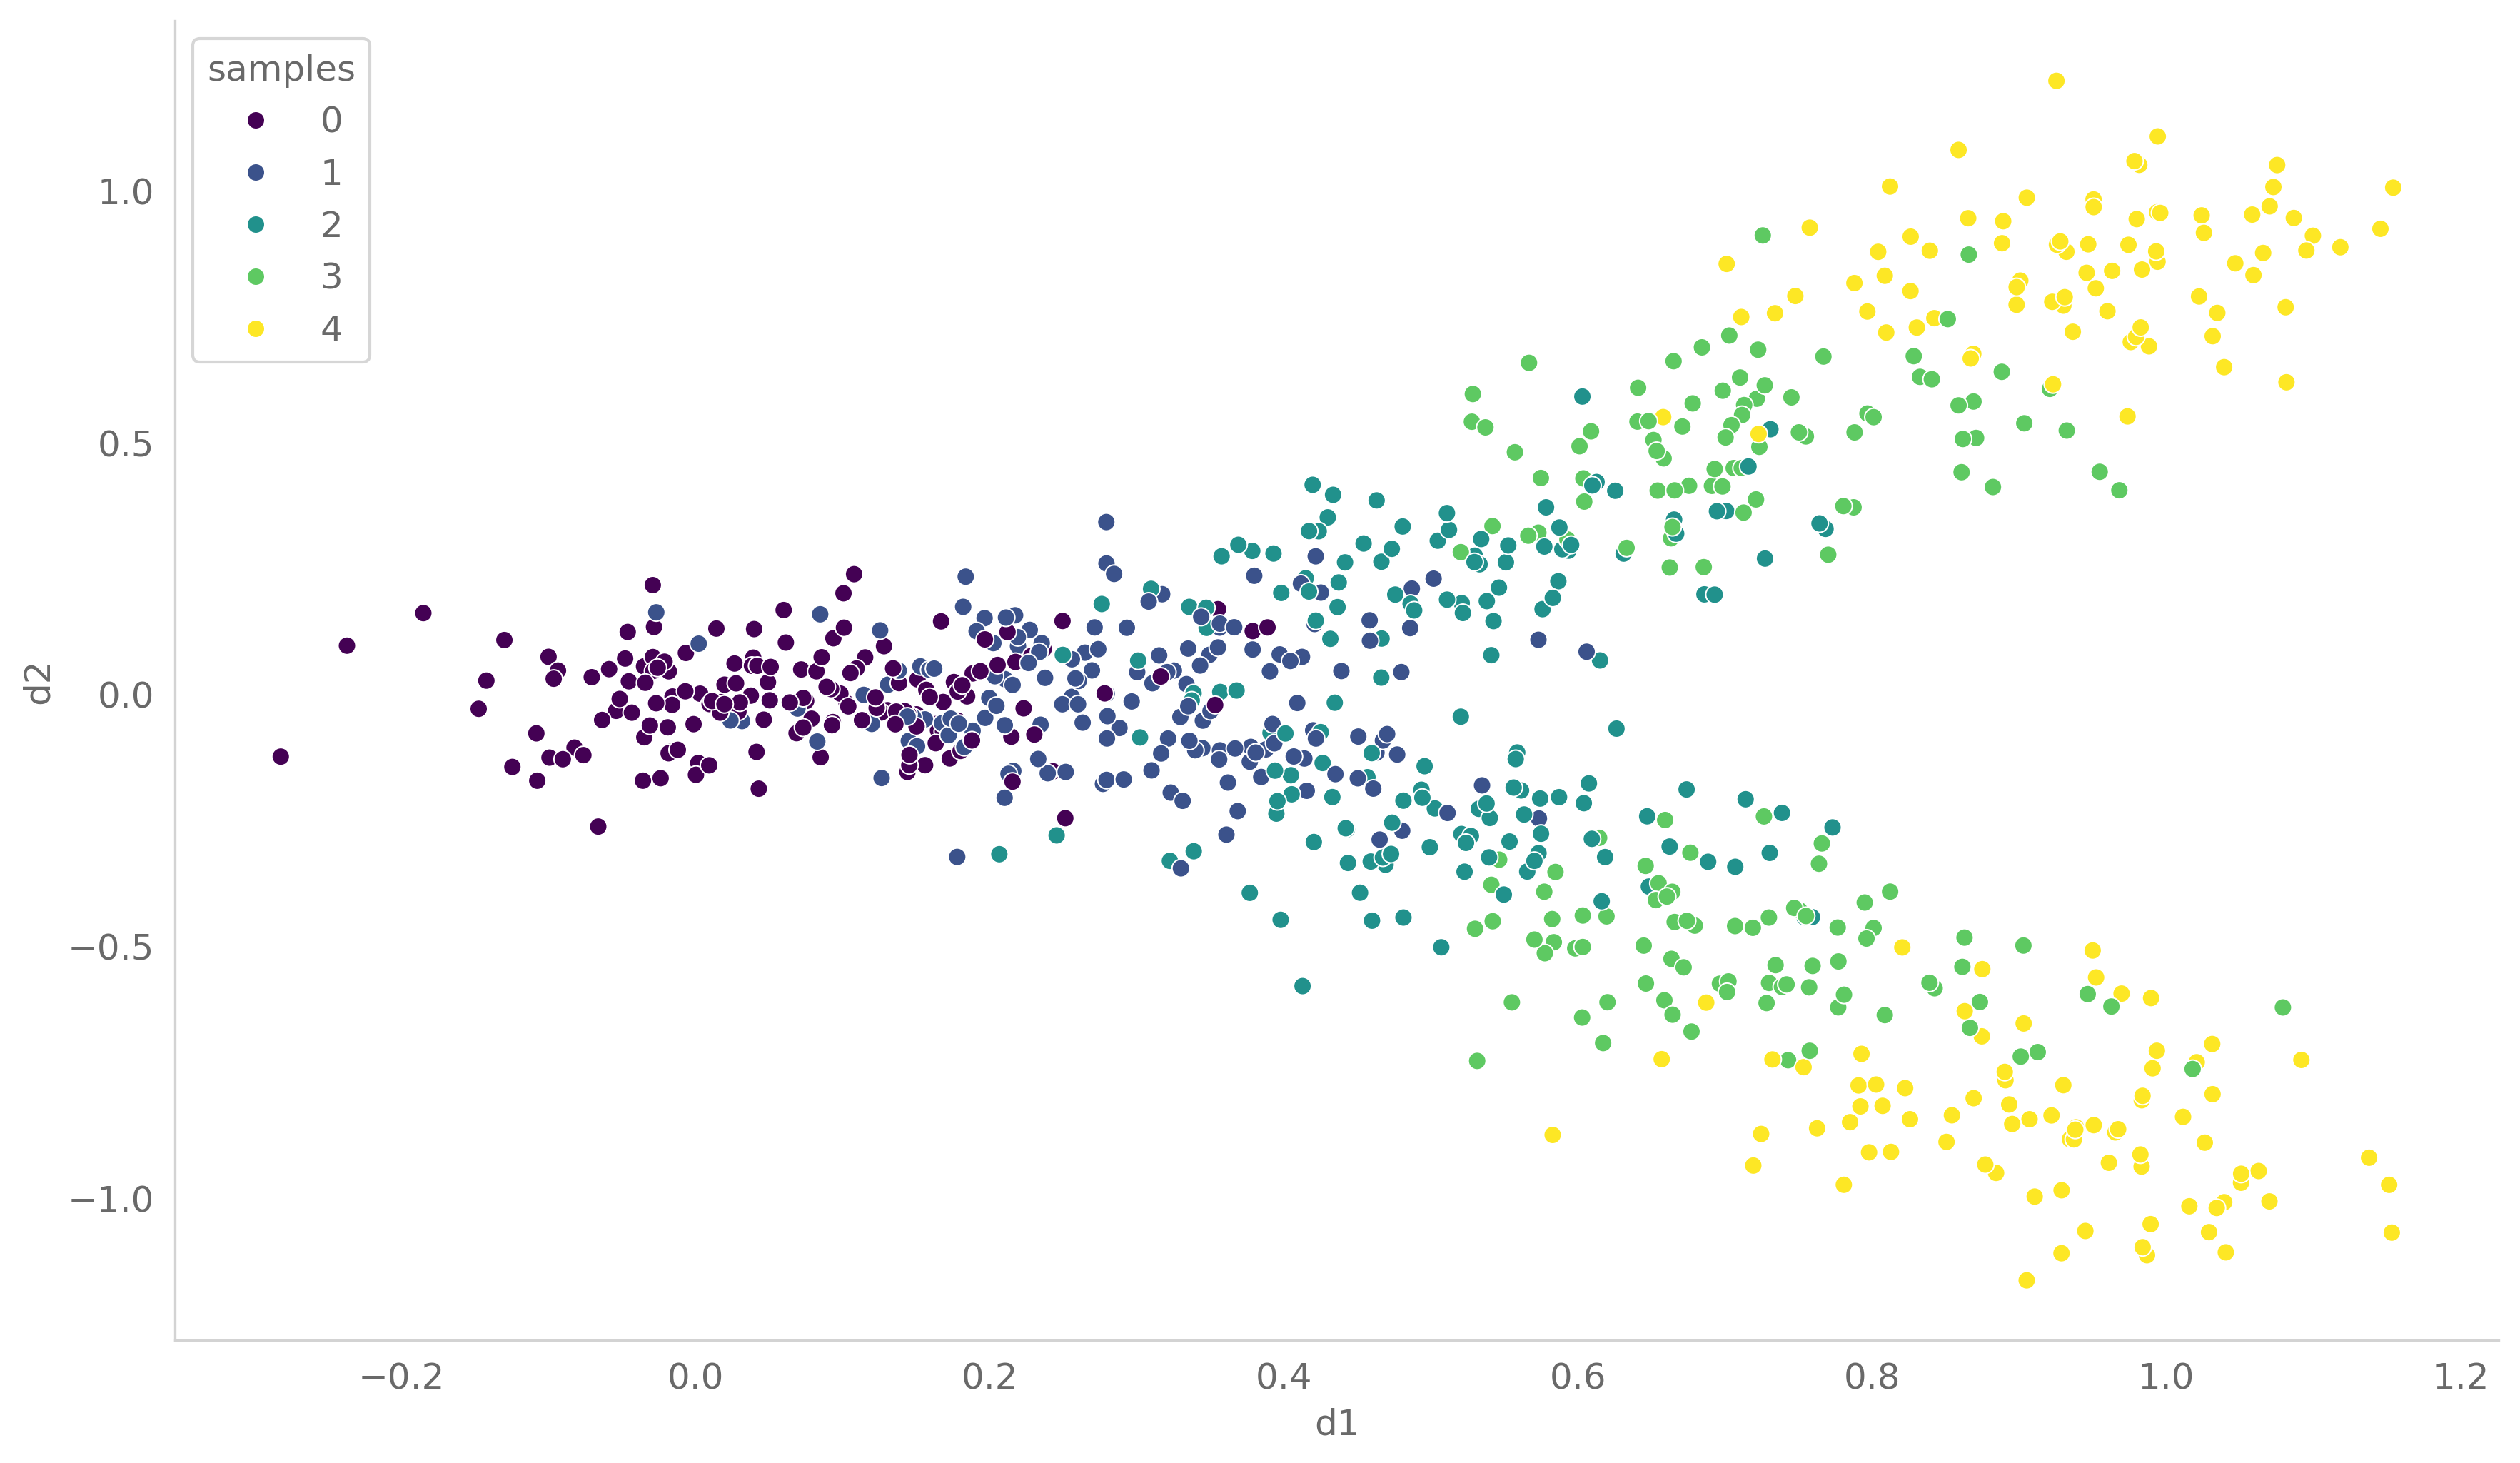

In [90]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

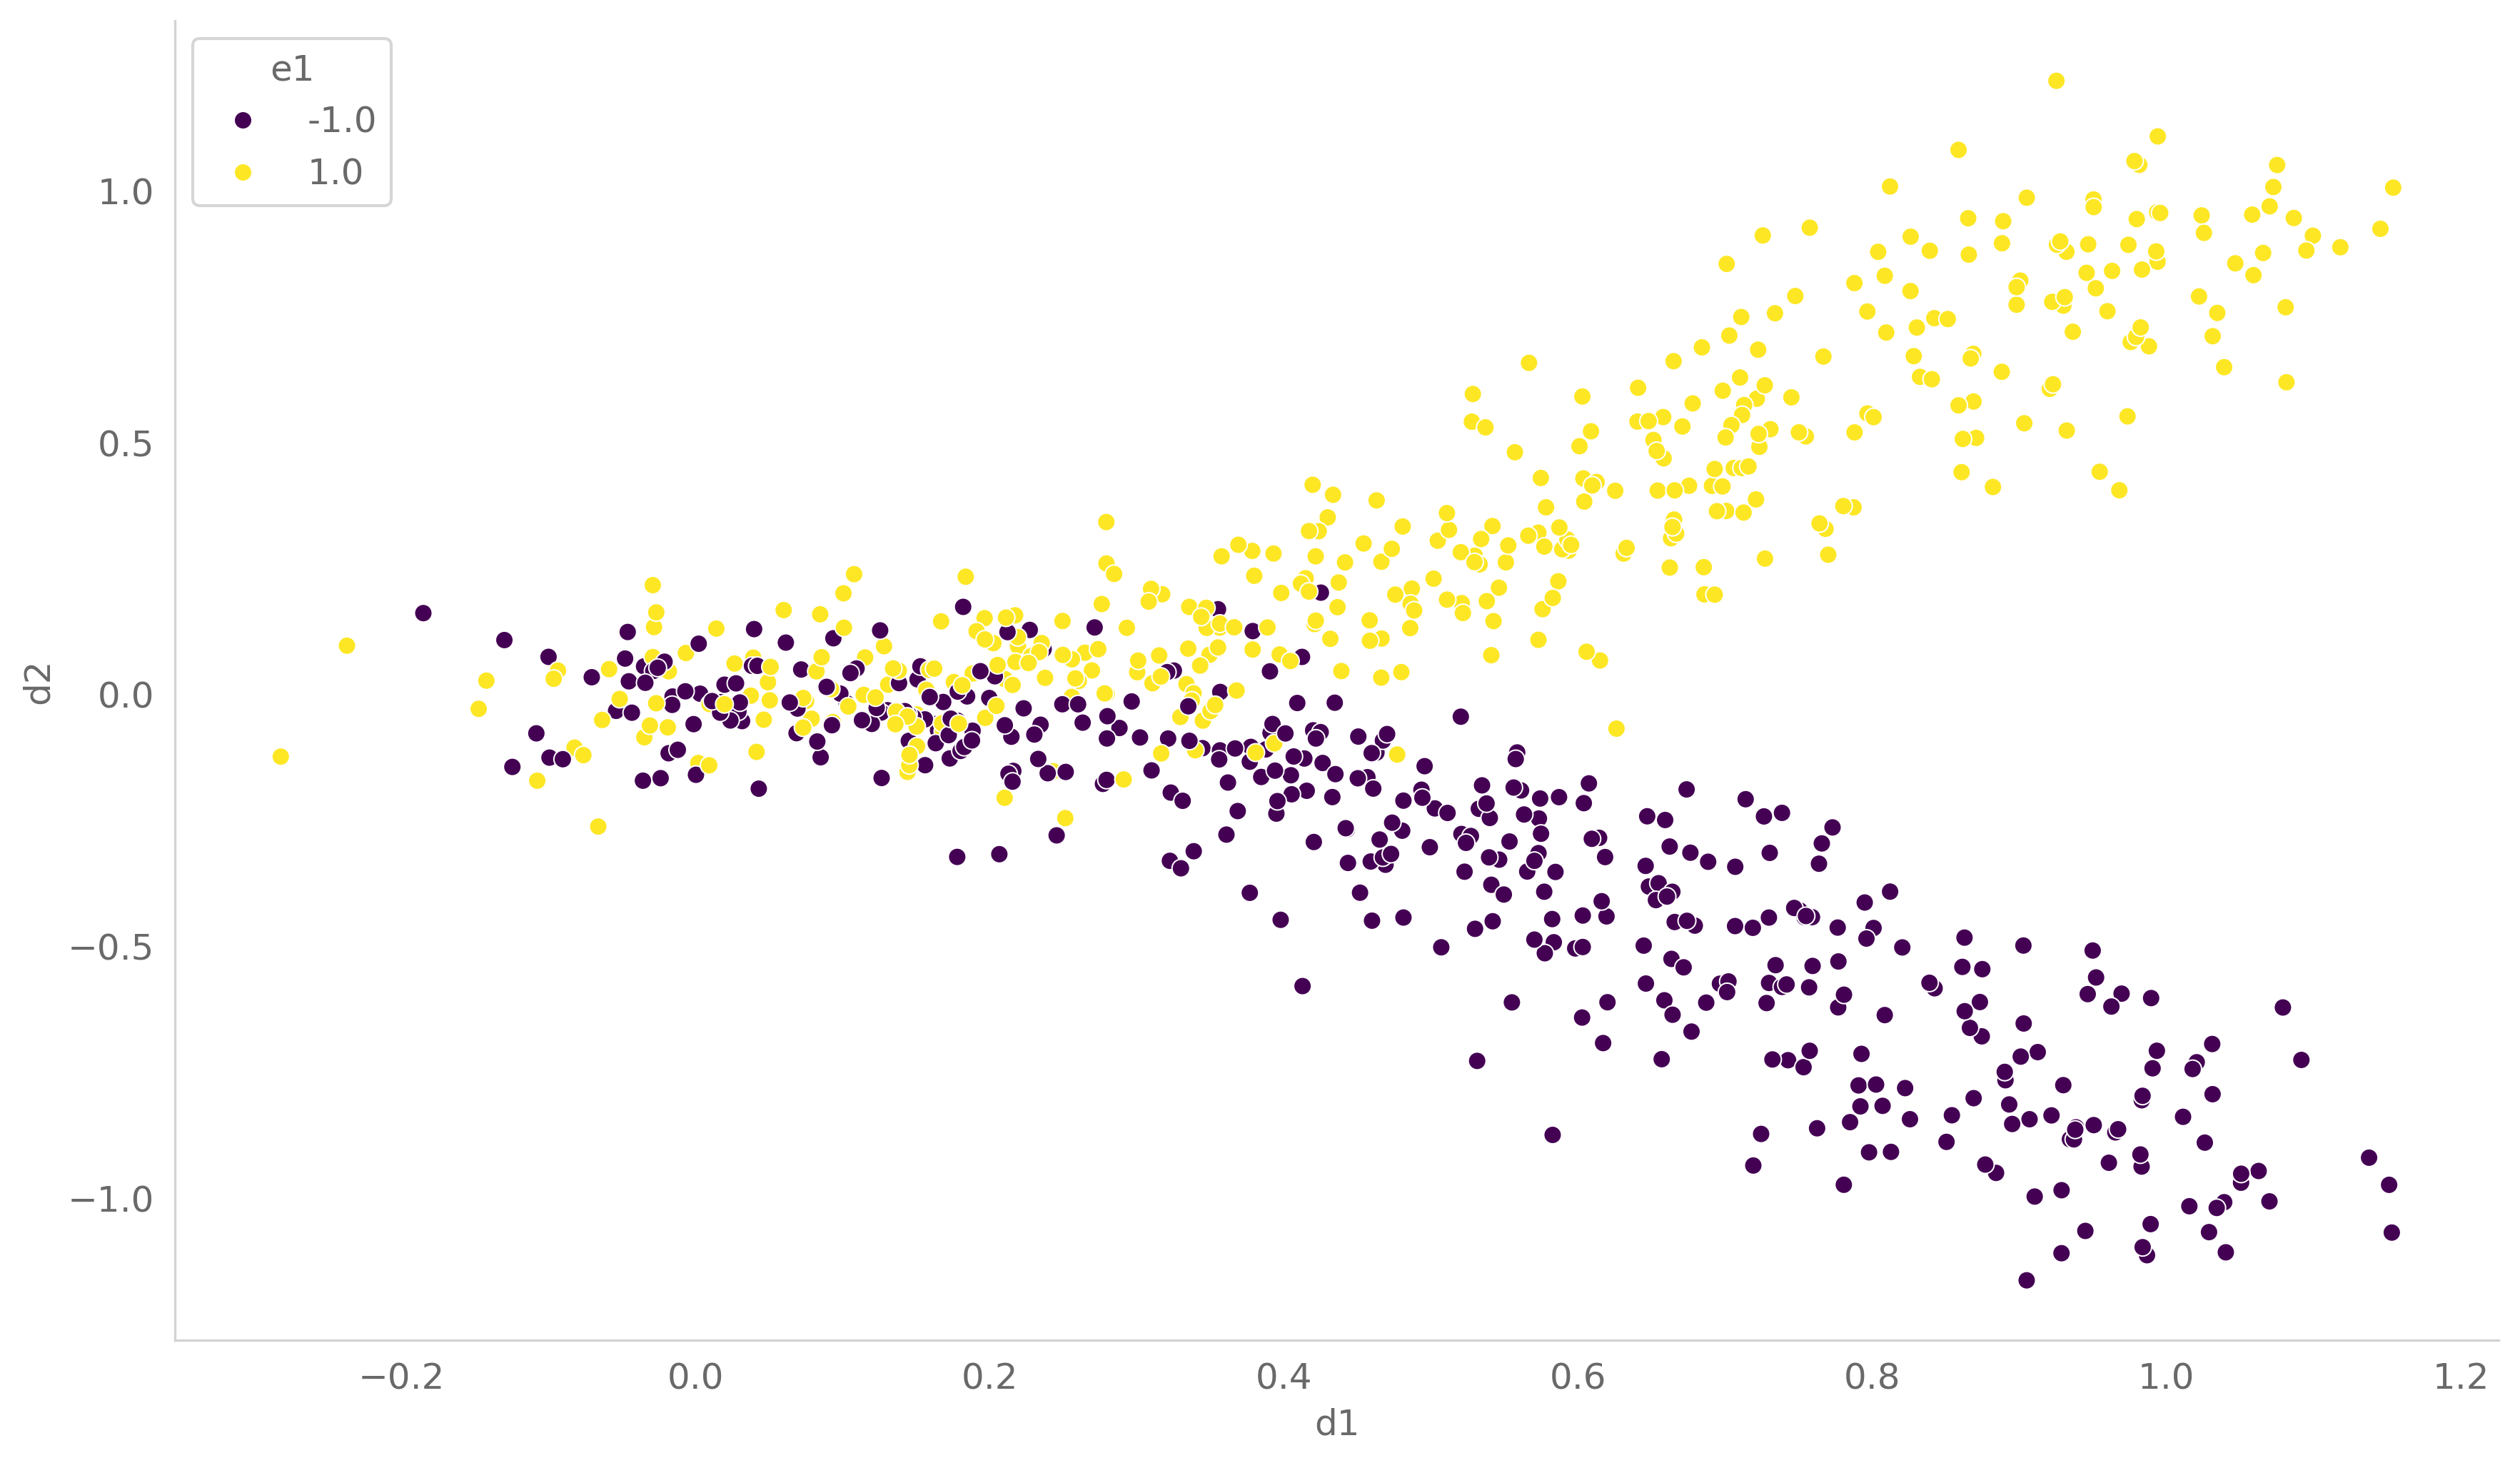

In [91]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='e1', palette='viridis');

In [92]:
df_copy = df.copy()
df = df.drop(columns=['e1'])

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [93]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [94]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [95]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.1
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 3
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [96]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

# Specify parameters

In [97]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 35

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
# sde_scales = len(groups)*[0.1] 
sde_scales = len(groups)*[0.] 

if recon:    
    model_features = gae_embedded_dim

# model = make_model(
#     model_features, layers, which='sde', method='euler',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda
# )

# model = make_model(
#     model_features, layers, which='sde', method='reversible_heun', sde_type='stratonovich', adjoint_method='adjoint_reversible_heun',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )

# model = make_model(
#     model_features, layers, which='sde', method='euler', sde_type='ito', 
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )
# model2 = make_model(
#     model_features, layers, which='sde', method='euler', sde_type='ito', 
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )
# model = make_model(
#     model_features, layers, which='ode', method='euler', 
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )
# model2 = make_model(
#     model_features, layers, which='ode', method='euler',  
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )

model = make_model(
    model_features, layers, which='ode', method='rk4', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)
model2 = make_model(
    model_features, layers, which='ode', method='rk4',  
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)


In [98]:
model.norm

[]

In [99]:
# Basically "batch size"
# sample_size=(60, )
sample_size=(60, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name, covariance_lambda=100.0, detach_dist_for_plan=False)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [100]:
opts = {
    'phate_dims': 2,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n
}

In [101]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [102]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [103]:
criterion2 = config_criterion(criterion_name, which='emd', covariance_lambda=0.0, detach_dist_for_plan=False)
start_time = time.time()
optimizer2 = torch.optim.AdamW(model2.parameters())

local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model2, df=df, groups=groups, optimizer=optimizer2, 
    criterion=criterion2, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    # lambda_density=10,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=False, 
    lambda_energy=0.001,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

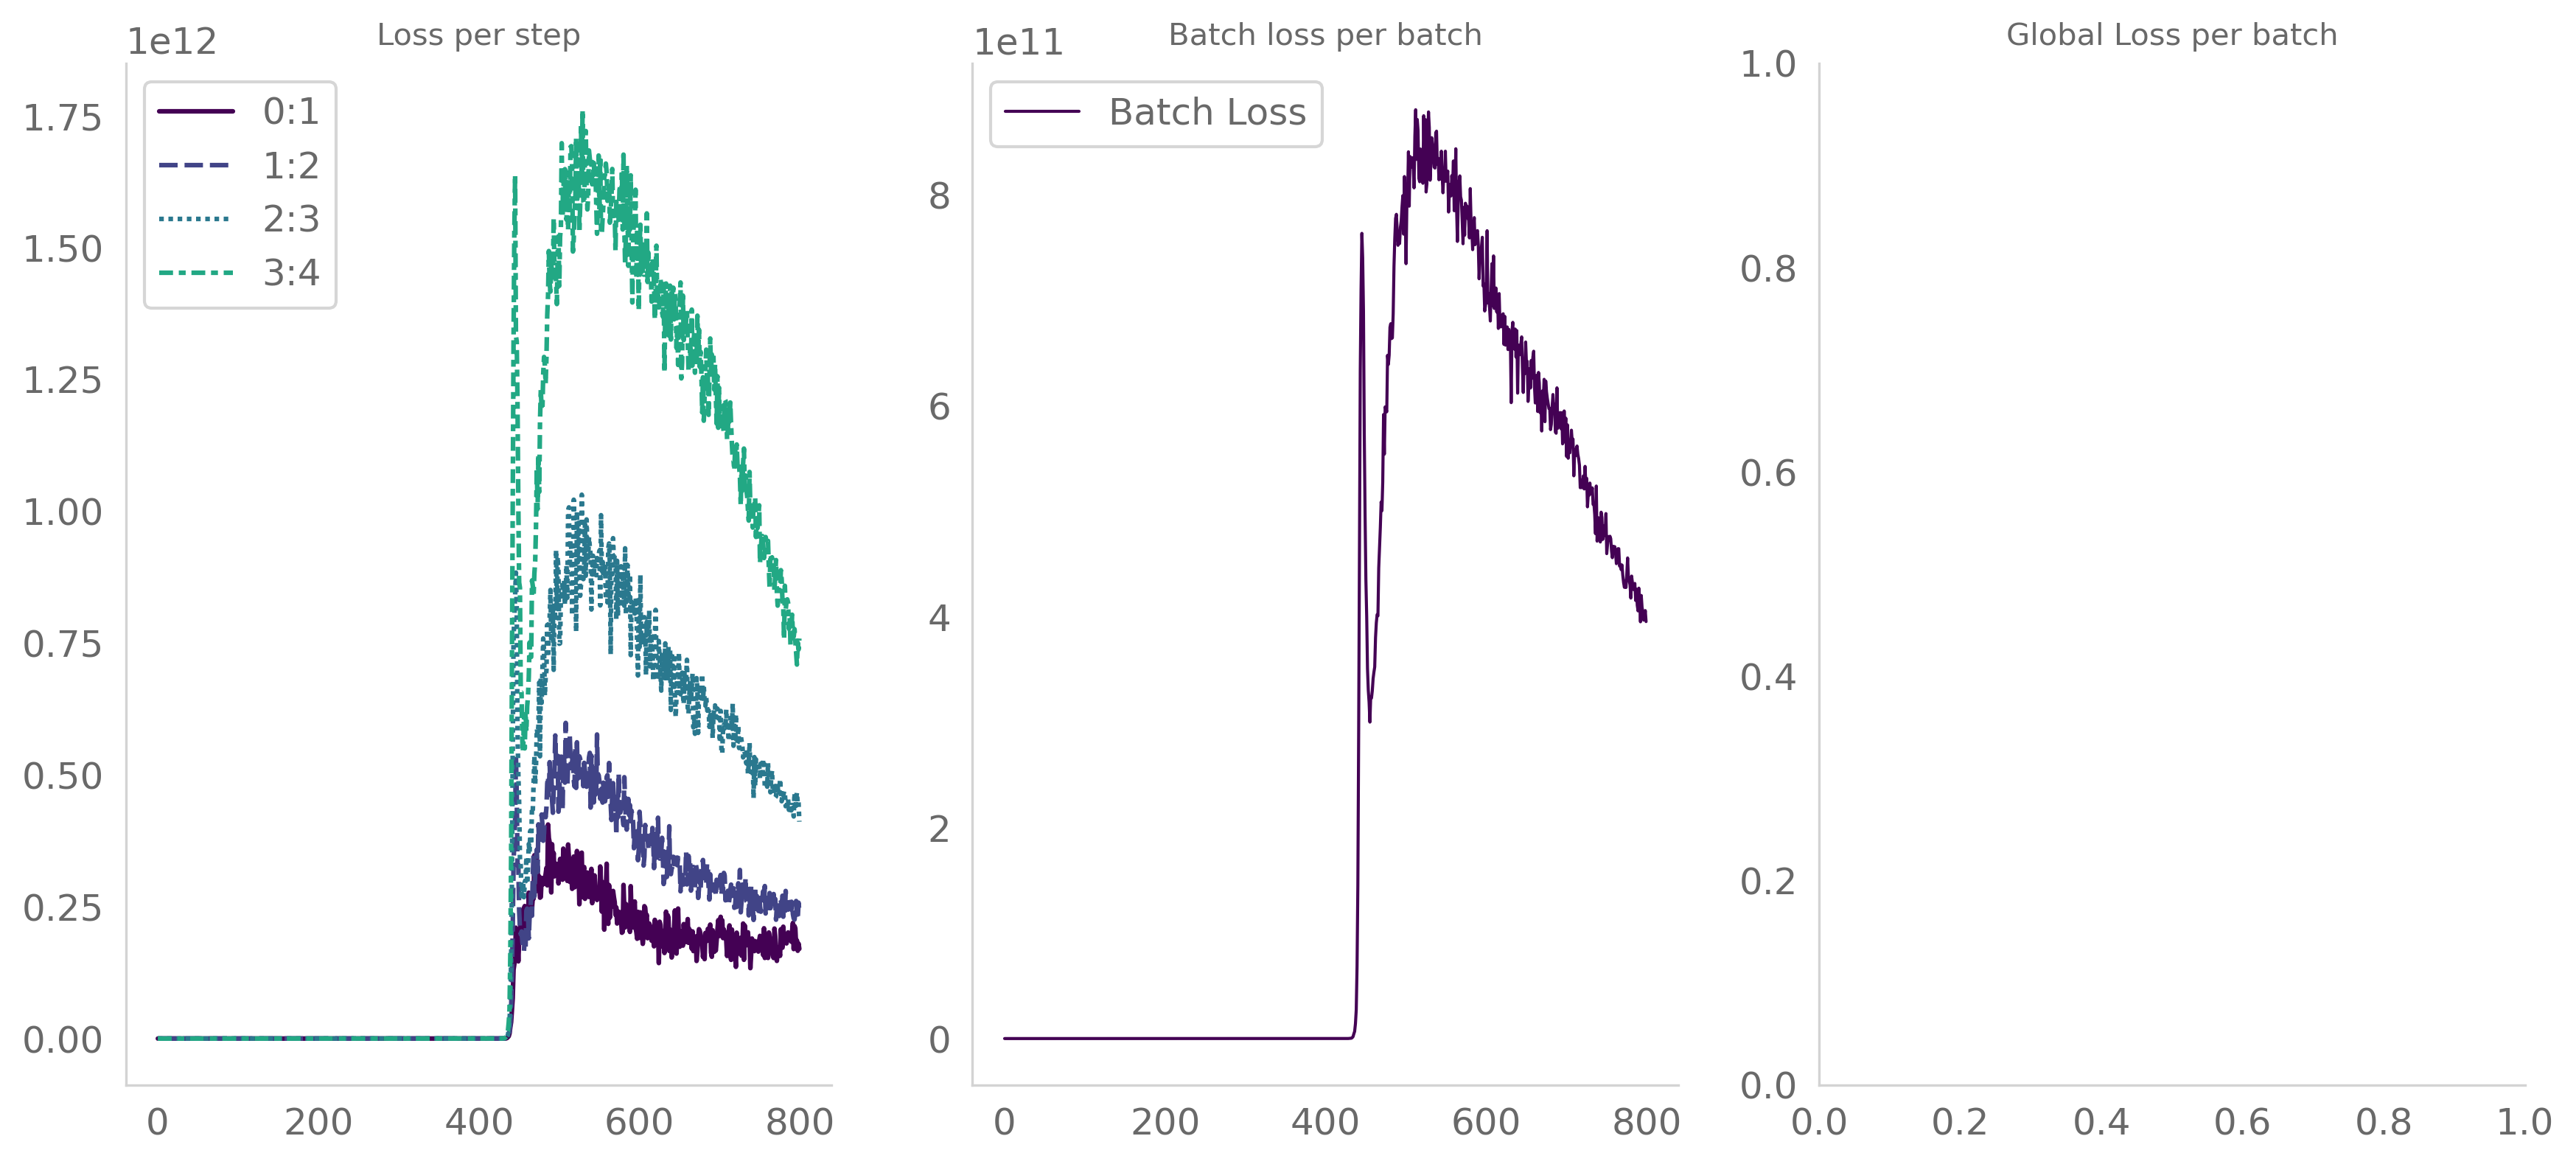

In [104]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [105]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

/Users/xingzhi/Research/MIOFlow_conditional/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


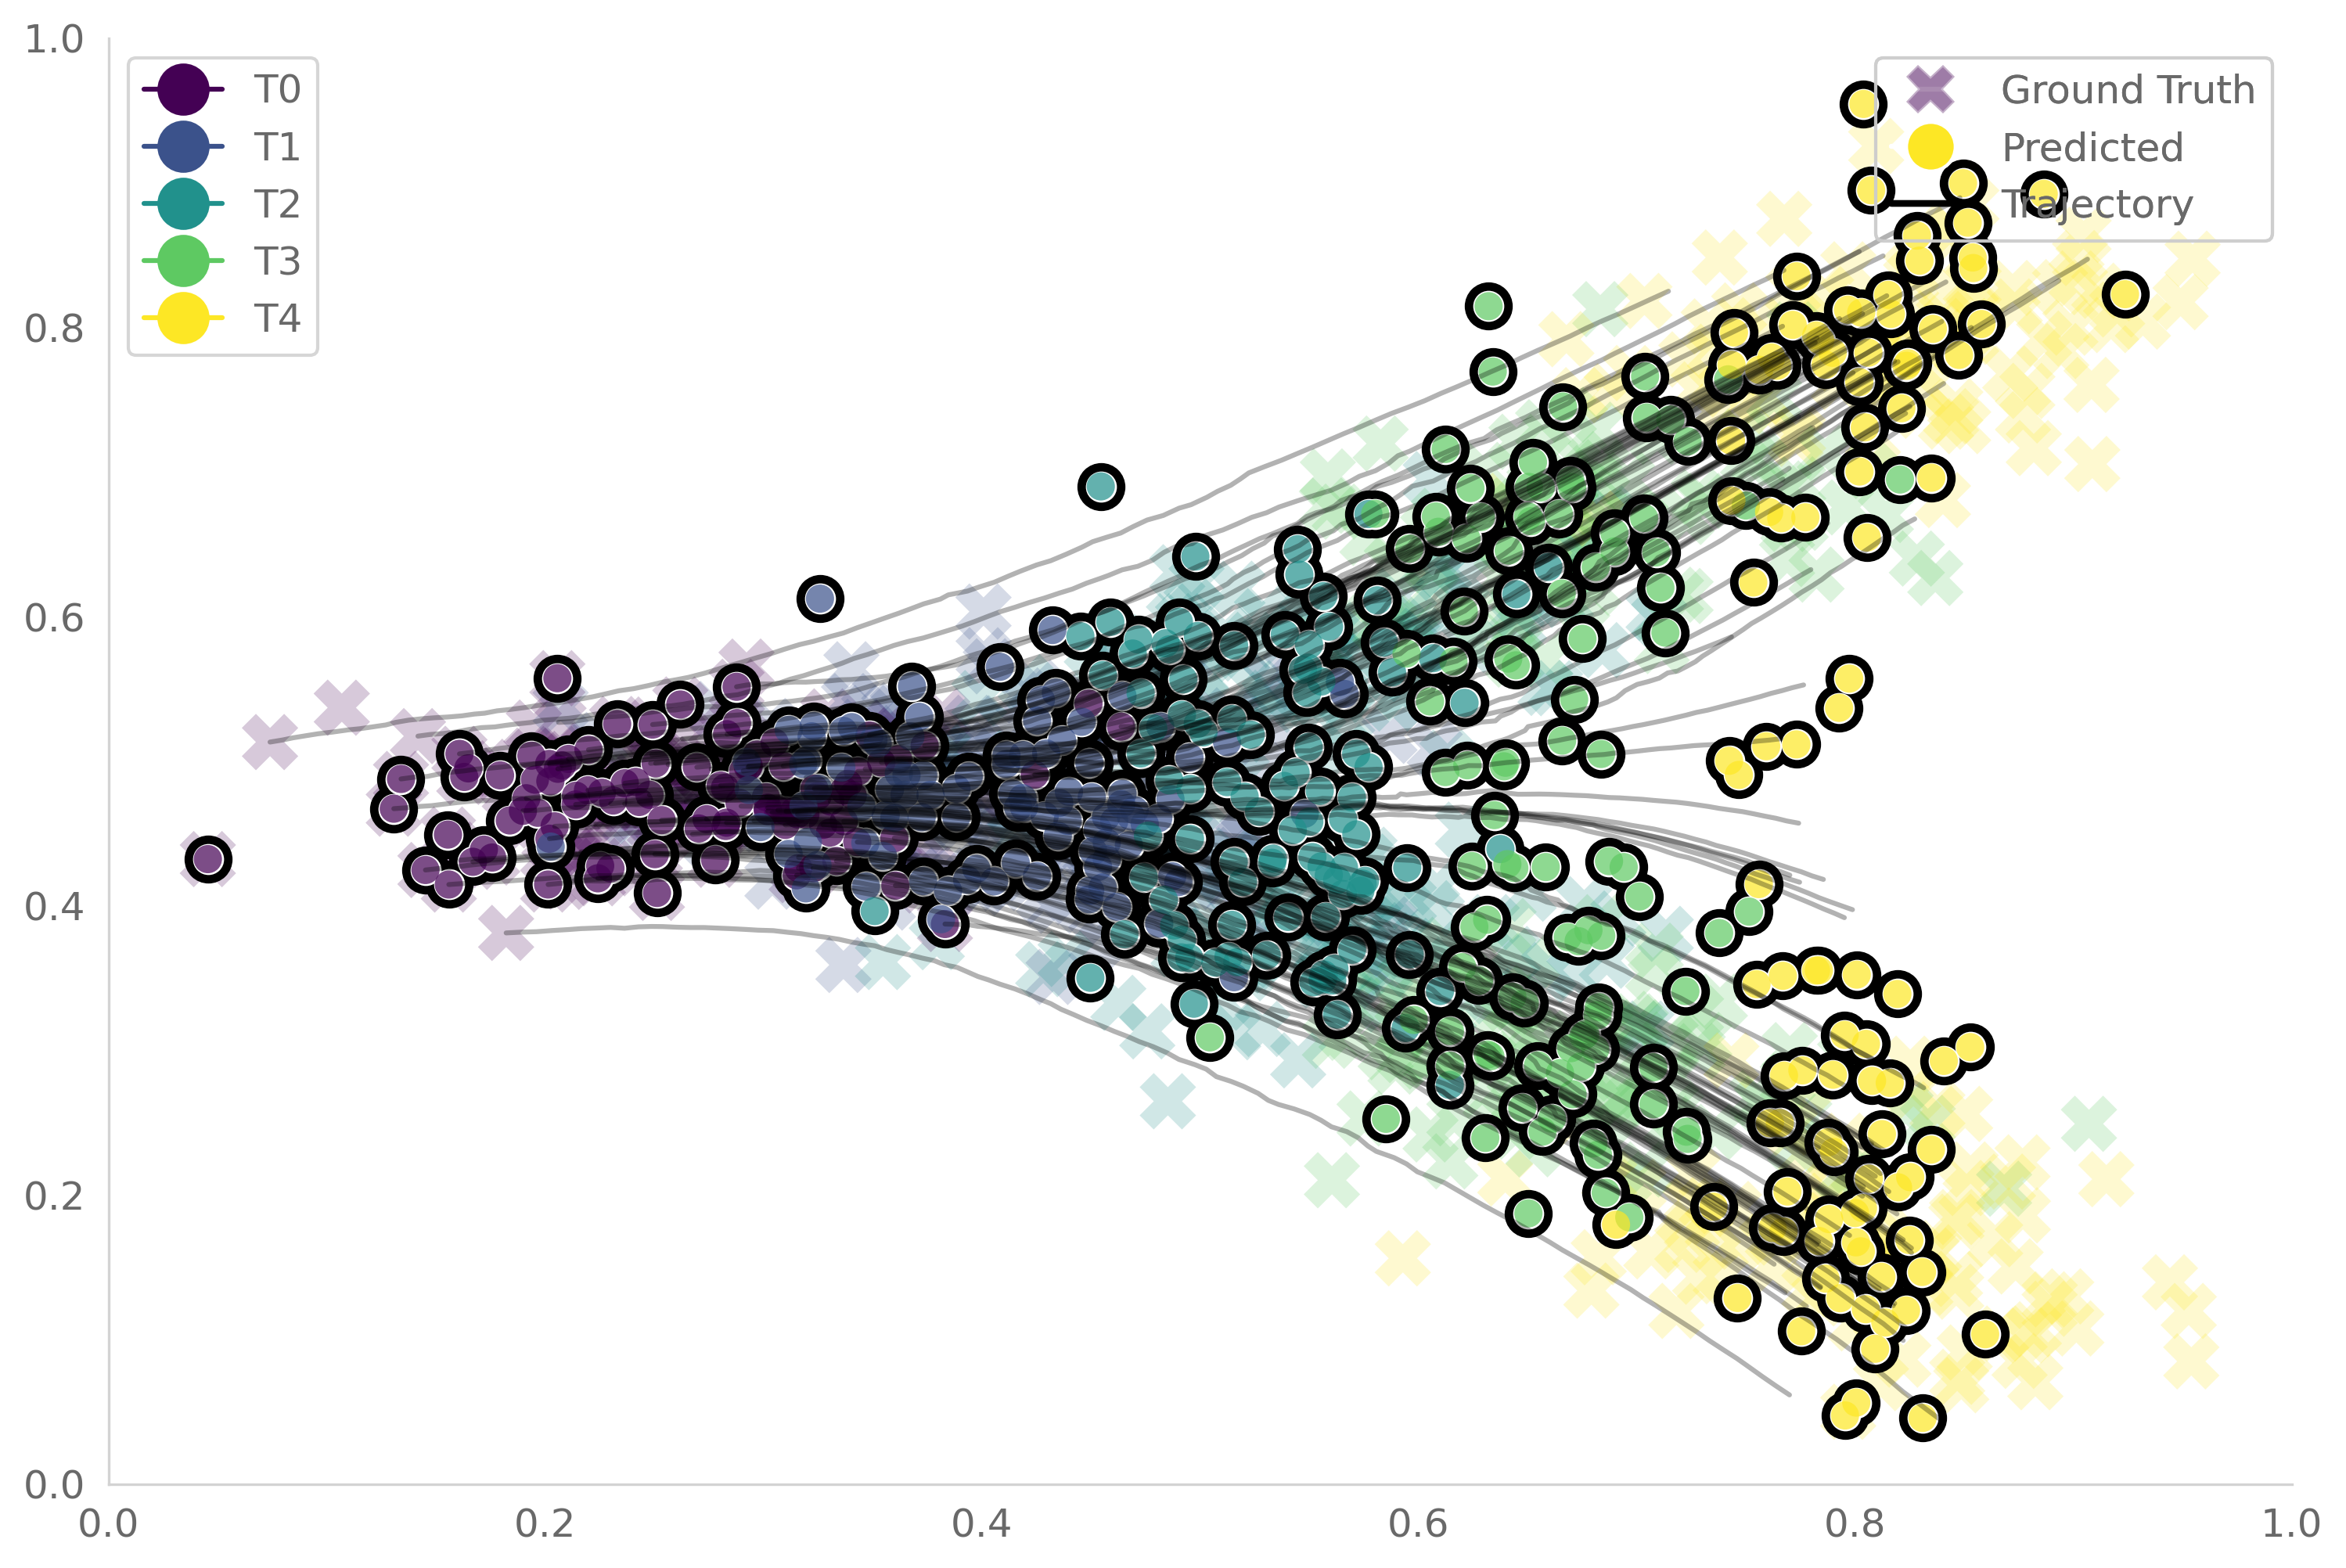

In [106]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

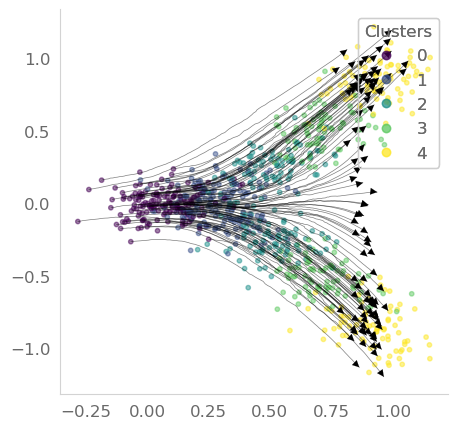

In [107]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['d1'], df['d2'],
                c=df['samples'] , cmap='viridis', s=10, alpha=.5)
# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))

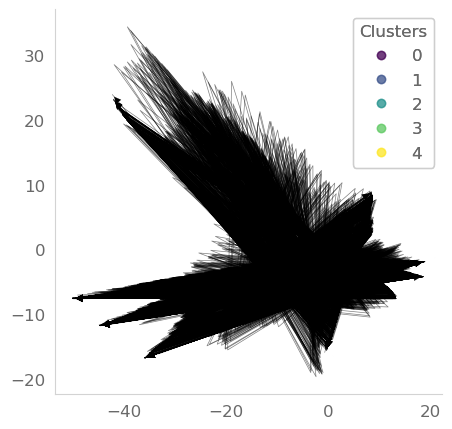

In [108]:
np.random.seed(32)
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model2(data_t0, sample_time, return_whole_sequence=True)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['d1'], df['d2'],
                c=df['samples'] , cmap='viridis', s=10, alpha=.5)
# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)
for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black');
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=.1))

+-----------------------------------+-------------------+-------------+
| Model                             |   Covariance Loss |     OT Loss |
+===================================+===================+=============+
| Model 1 (trained with covariance) |      15.3397      | 0.120262    |
+-----------------------------------+-------------------+-------------+
| Model 2 (trained with OT)         |       5.42562e+17 | 1.12272e+16 |
+-----------------------------------+-------------------+-------------+


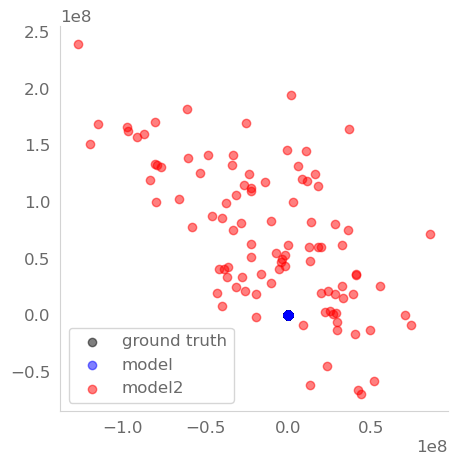

In [109]:
t0 = 0
t1 = 4
data_t0 = sample(
    df, t0, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
data_t1 = sample(
    df, t1, size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
sample_time1 = torch.tensor([t0,t1], dtype=data_t0.dtype, device=data_t0.device)
with torch.no_grad():
    x_traj1 = model(data_t0, sample_time1, return_whole_sequence=False)
    x_traj2 = model2(data_t0, sample_time1, return_whole_sequence=False)

loss1_cov = criterion(x_traj1, data_t1)
loss2_cov = criterion(x_traj2, data_t1)
loss1_ot = criterion2(x_traj1, data_t1)
loss2_ot = criterion2(x_traj2, data_t1)

from tabulate import tabulate
data = [
    ["Model 1 (trained with covariance)", loss1_cov.item(), loss1_ot.item()],
    ["Model 2 (trained with OT)", loss2_cov.item(), loss2_ot.item()]
]
headers = ["Model", "Covariance Loss", "OT Loss"]
print(tabulate(data, headers=headers, tablefmt="grid"))

plt.figure(figsize=(5, 5))
plt.scatter(data_t1[:,0], data_t1[:,1], alpha=.5, color='Black', label='ground truth')
plt.scatter(x_traj1[:,0], x_traj1[:,1], alpha=.5, color='Blue', label='model')
plt.scatter(x_traj2[:,0], x_traj2[:,1], alpha=.5, color='Red', label='model2')
plt.legend()


In [110]:
x_traj[-1, ...]


tensor([[-50.1147,  -7.5073],
        [-35.9490, -16.7259],
        [-36.0053, -16.7095],
        [-50.1091,  -7.5070],
        [-35.9764, -16.7185],
        [-44.8372, -11.7252],
        [ 13.4018,  -7.5688],
        [ 18.9877,  -1.8488],
        [-50.1124,  -7.5047],
        [-36.0147, -16.7015],
        [-50.1106,  -7.5075],
        [-50.1066,  -7.5073],
        [  8.4816,   8.9778],
        [-42.0834,  23.0962],
        [-35.9196, -16.7326],
        [-44.8539, -11.7205],
        [ -0.3033, -15.5583],
        [-44.8534, -11.7198],
        [-50.1165,  -7.5084],
        [  8.5608,   8.9170],
        [-35.9204, -16.7304],
        [-35.8983, -16.7393],
        [-44.8304, -11.7242],
        [-35.9153, -16.7347],
        [ 18.7429,  -4.2030],
        [ -0.2598, -15.5189],
        [-42.3322,  23.9734],
        [-50.1152,  -7.5062],
        [-44.8570, -11.7174],
        [-50.1099,  -7.5072],
        [-44.8538, -11.7175],
        [ 18.9907,  -1.8558],
        [-44.8419, -11.7257],
        [-

In [111]:
model.func(sample_time[-1], data_t0)

tensor([[ 0.3207, -0.2179],
        [ 0.5443, -0.2329],
        [ 0.4389,  0.2000],
        [ 0.2773, -0.2888],
        [ 0.3892,  0.2048],
        [ 0.5388, -0.2426],
        [ 0.2903, -0.2634],
        [ 0.3414, -0.0926],
        [ 0.2764, -0.0346],
        [ 0.1928, -0.0640],
        [ 0.4848, -0.0296],
        [ 0.3401,  0.0273],
        [ 0.3103,  0.0075],
        [ 0.4951,  0.1393],
        [ 0.4853,  0.3166],
        [ 0.3714, -0.0864],
        [ 0.3343, -0.0739],
        [ 0.3491, -0.2877],
        [ 0.2625, -0.1198],
        [ 0.4663, -0.0151],
        [ 0.6229,  0.0762],
        [ 0.4288, -0.2742],
        [ 0.2890,  0.1137],
        [ 0.2626, -0.2254],
        [ 0.4541,  0.0018],
        [ 0.4494,  0.0590],
        [ 0.6465,  0.3003],
        [ 0.4378, -0.0322],
        [ 0.2027, -0.1608],
        [ 0.3464, -0.2238],
        [ 0.2101, -0.0067],
        [ 0.2385, -0.1099],
        [ 0.3422, -0.2393],
        [ 0.3815, -0.0799],
        [ 0.4373, -0.0053],
        [ 0.3743, -0

In [112]:
model.gunc(sample_time[-1], data_t0)

AttributeError: 'ToyModel' object has no attribute 'gunc'

In [66]:
# saving the trajectories and generated points
# np.save(os.path.join(exp_dir,'trajectories_petal.npy'),trajectories)
# np.save(os.path.join(exp_dir,'generated_petal.npy'),generated)

In [67]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [68]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [69]:
RES_DIR

'/Users/xingzhi/Research/MIOFlow_conditional/results'

In [70]:
exp_dir

'/Users/xingzhi/Research/MIOFlow_conditional/results/test'

In [71]:
# np.random.seed(32)
# groups = sorted(df['samples'].unique())
# sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
# from MIOFlow.utils import sample
# data_t0 = sample(
#     df, np.min(groups), size=(n_points, ), 
#     replace=False, to_torch=True, use_cuda=use_cuda
# )
# sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

# with torch.no_grad():
#     x_traj = model(data_t0, sample_time, return_whole_sequence=True)

# savepath = './'
# np.save(os.path.join(savepath, 'trajectories.npy'), x_traj)

In [72]:
trajectories.shape

(100, 100, 2)

In [73]:
model2 = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
)

In [74]:
model2.gunc.seq[0].weight.data

tensor([[ 0.3065,  0.2271,  0.0136,  0.1255,  0.3302],
        [-0.2326, -0.1916,  0.0616, -0.0812, -0.1920],
        [-0.4182, -0.0946,  0.2320, -0.1344, -0.3020],
        [-0.1975, -0.2818,  0.3837, -0.3691, -0.4035],
        [ 0.3342, -0.0652, -0.1211,  0.4120,  0.0860],
        [ 0.1394,  0.0260,  0.3611,  0.2454,  0.3716],
        [-0.4015, -0.0160,  0.0236,  0.2103,  0.0681],
        [ 0.0613, -0.1159,  0.0539,  0.0653,  0.1302],
        [-0.0988,  0.4365, -0.0285,  0.1533, -0.2444],
        [ 0.2338, -0.0360,  0.0910,  0.3849,  0.0742],
        [-0.0036,  0.2756,  0.4301,  0.3876,  0.1225],
        [-0.3694,  0.1377,  0.1143,  0.2488, -0.0092],
        [-0.1413,  0.1682, -0.0622,  0.1047,  0.0754],
        [ 0.1489,  0.1525,  0.2751, -0.2878, -0.2400],
        [-0.2227,  0.0166, -0.3345, -0.3423, -0.2823],
        [ 0.0469, -0.2639,  0.1252, -0.4240, -0.0359]])